# 模型选择、欠拟合和过拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 1.数据

给定$x$，我们将**使用以下三阶多项式来生成训练和测试数据的标签：**

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6532],
         [-1.4111]]),
 tensor([[ 1.0000e+00, -6.5317e-01,  2.1332e-01, -4.6444e-02,  7.5840e-03,
          -9.9074e-04,  1.0785e-04, -1.0064e-05,  8.2168e-07, -5.9633e-08,
           3.8951e-09, -2.3129e-10,  1.2589e-11, -6.3254e-13,  2.9511e-14,
          -1.2851e-15,  5.2460e-17, -2.0156e-18,  7.3142e-20, -2.5144e-21],
         [ 1.0000e+00, -1.4111e+00,  9.9556e-01, -4.6827e-01,  1.6519e-01,
          -4.6619e-02,  1.0964e-02, -2.2101e-03,  3.8983e-04, -6.1119e-05,
           8.6244e-06, -1.1063e-06,  1.3009e-07, -1.4121e-08,  1.4232e-09,
          -1.3389e-10,  1.1808e-11, -9.8009e-13,  7.6832e-14, -5.7061e-15]]),
 tensor([ 3.2274, -2.7472]))

### 2.评价模型

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失和,样本数
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

### 3.训练模型

In [10]:
def evaluate_accuracy(net, data_iter):
    """计算指定数据集上的模型精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  #不累计梯度，设置为评估模式
    metric = d2l.Accumulator(2)  #正确预测数、预测总数
    for X, y in data_iter:
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = d2l.Accumulator(3) # 准确度、正确数量、总数量
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), d2l.accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [11]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

RuntimeError: grad can be implicitly created only for scalar outputs

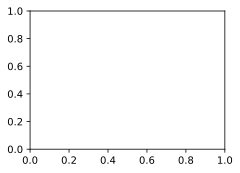

In [12]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

In [ ]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

In [ ]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)